In [1]:
from sklearn.model_selection import GridSearchCV
from stratmanager import StrategyManager

# Data Management
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator

from ta import add_all_ta_features
import ta

# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervised Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score
import pickle 
from datetime import datetime


# Reporting
import matplotlib.pyplot as plt
import yfinance
from sklearn.tree import plot_tree
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [2]:
stock_name = "TATACONSUM.NS"
df = yfinance.download (tickers = "{}".format(stock_name),start="2017-01-01",
                              interval = "1d", group_by = 'ticker', auto_adjust = True)


[*********************100%***********************]  1 of 1 completed


In [3]:
#df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [3]:
df.describe()
df["Returns"] = df["Close"].pct_change()

df["RSI"] =  RSIIndicator(close=df["Close"], window=14).rsi()
df["Range"] = df["High"] / df["Low"] - 1
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["MA_20"] = df["Close"].rolling(window=20).mean()
df["MA_200"] = df["Close"].rolling(window=200).mean()
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])


df['date'] = pd.to_datetime(df.index)
df.set_index("date", inplace=True)
df["TARGET"] = -1
df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1
df.dropna(inplace=True)

Non-Stationary Features Found: 8


In [5]:
#fb prophet
from prophet import Prophet
fb_df = df.copy()
fb_df

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,Open,High,Low,Close,Volume,Returns,RSI,Range,MA_50,MA_20,MA_200,Avg_Range,OBV,TARGET
date,,,,,,,,,,,,,,
2017-10-23,195.009348,196.859799,192.257397,192.731873,2952899,-0.007331,46.642060,0.023939,190.387007,195.638027,150.746609,0.029587,187336302,1
2017-10-24,193.585929,199.516871,193.158904,198.947495,3568231,0.032250,55.470146,0.032916,191.289460,196.041331,151.172255,0.029817,190904533,-1
2017-10-25,200.228580,200.703056,192.636976,194.819565,2640192,-0.020749,49.600814,0.041872,192.225125,196.451753,151.573116,0.030609,188264341,1
2017-10-26,194.487427,200.086245,193.016551,199.089844,4964383,0.021919,54.915365,0.036627,193.090568,196.696109,151.995329,0.031275,193228724,1
2017-10-27,200.513264,210.477245,199.042388,209.243607,8891566,0.051001,64.500891,0.057449,193.882942,197.735210,152.464856,0.031776,202120290,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,0.010941,54.342271,0.021853,831.647000,852.439993,766.056272,0.019186,775671570,-1
2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,-0.000058,54.319546,0.009795,833.523999,852.462494,766.608229,0.018793,774216781,-1
2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,-0.002968,53.099661,0.011956,835.337000,852.522495,767.219395,0.018600,773228969,-1


In [7]:
#renaming variables
#transform the date variable
fb_df["Date"] = pd.to_datetime(fb_df.index)
#data.Date
fb_df.tail(10)
fb_df = fb_df.rename(columns = {'Close': 'y',
                     'Date': 'ds'})


In [9]:
m = Prophet(
            #holidays = holidays,
            #seasonality_mode = 'multiplicative',
           # seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(fb_df)


08:23:04 - cmdstanpy - INFO - Chain [1] start processing
08:23:05 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
forecast = m.predict(fb_df)
fb_df = fb_df.reset_index()
prophet_variables = forecast.loc[:, ["trend", "weekly","yearly"]]
df_xgb = pd.concat([fb_df, prophet_variables], axis = 1)
#df_xgb.dropna(inplace=True)
#df_xgb
df_xgb

,date,Open,High,Low,y,Volume,Returns,RSI,Range,MA_50,MA_20,MA_200,Avg_Range,OBV,TARGET,ds,trend,weekly,yearly
0,2017-10-23,195.009348,196.859799,192.257397,192.731873,2952899,-0.007331,46.642060,0.023939,190.387007,195.638027,150.746609,0.029587,187336302,1,2017-10-23,241.544219,1.995182,-4.676355
1,2017-10-24,193.585929,199.516871,193.158904,198.947495,3568231,0.032250,55.470146,0.032916,191.289460,196.041331,151.172255,0.029817,190904533,-1,2017-10-24,241.942074,2.588391,-4.693264
2,2017-10-25,200.228580,200.703056,192.636976,194.819565,2640192,-0.020749,49.600814,0.041872,192.225125,196.451753,151.573116,0.030609,188264341,1,2017-10-25,242.339929,3.422598,-4.629669
3,2017-10-26,194.487427,200.086245,193.016551,199.089844,4964383,0.021919,54.915365,0.036627,193.090568,196.696109,151.995329,0.031275,193228724,1,2017-10-26,242.737785,3.197329,-4.493139
4,2017-10-27,200.513264,210.477245,199.042388,209.243607,8891566,0.051001,64.500891,0.057449,193.882942,197.735210,152.464856,0.031776,202120290,1,2017-10-27,243.135640,1.865051,-4.291880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,0.010941,54.342271,0.021853,831.647000,852.439993,766.056272,0.019186,775671570,-1,2023-07-28,793.118353,1.865051,18.807178
1427,2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,-0.000058,54.319546,0.009795,833.523999,852.462494,766.608229,0.018793,774216781,-1,2023-07-31,793.493297,1.995182,18.229004
1428,2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,-0.002968,53.099661,0.011956,835.337000,852.522495,767.219395,0.018600,773228969,-1,2023-08-01,793.618278,2.588391,18.212963
1429,2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731,-0.015991,46.993503,0.020043,836.797000,852.379993,767.689113,0.018494,771624238,-1,2023-08-02,793.743260,3.422598,18.310635


<Axes: >

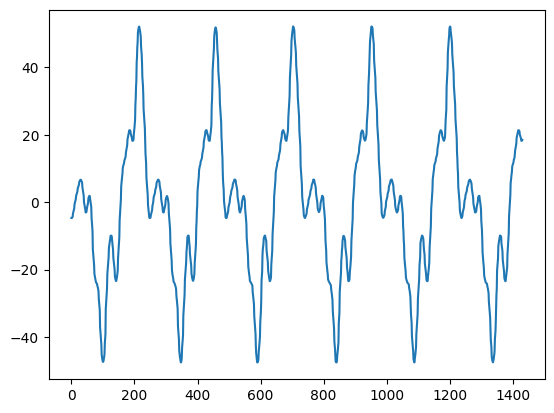

In [51]:
df_xgb.yearly.plot()

In [182]:
# Identify non-stationary columns

df = df_xgb.dropna()
df['yearly_c'] = df['yearly'].pct_change()

In [188]:
df.dropna(inplace=True)

In [189]:
df

,date,Open,High,Low,y,Volume,Returns,RSI,Range,MA_50,MA_20,MA_200,Avg_Range,OBV,TARGET,ds,trend,weekly,yearly,yearly_c
1,2017-10-24,193.585929,199.516871,193.158904,198.947495,3568231,0.032250,55.470146,0.032916,191.289460,196.041331,151.172255,0.029817,190904533,-1,2017-10-24,241.942074,2.588391,-4.693264,0.003616
2,2017-10-25,200.228580,200.703056,192.636976,194.819565,2640192,-0.020749,49.600814,0.041872,192.225125,196.451753,151.573116,0.030609,188264341,1,2017-10-25,242.339929,3.422598,-4.629669,-0.013550
3,2017-10-26,194.487427,200.086245,193.016551,199.089844,4964383,0.021919,54.915365,0.036627,193.090568,196.696109,151.995329,0.031275,193228724,1,2017-10-26,242.737785,3.197329,-4.493139,-0.029490
4,2017-10-27,200.513264,210.477245,199.042388,209.243607,8891566,0.051001,64.500891,0.057449,193.882942,197.735210,152.464856,0.031776,202120290,1,2017-10-27,243.135640,1.865051,-4.291880,-0.044793
5,2017-10-30,213.513886,218.495877,211.141510,215.222000,13953152,0.028571,68.718080,0.034831,194.508300,198.857344,152.966808,0.031900,216073442,1,2017-10-30,244.329205,1.995182,-3.386888,-0.210861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,0.010941,54.342271,0.021853,831.647000,852.439993,766.056272,0.019186,775671570,-1,2023-07-28,793.118353,1.865051,18.807178,-0.016355
1427,2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,-0.000058,54.319546,0.009795,833.523999,852.462494,766.608229,0.018793,774216781,-1,2023-07-31,793.493297,1.995182,18.229004,-0.030742
1428,2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,-0.002968,53.099661,0.011956,835.337000,852.522495,767.219395,0.018600,773228969,-1,2023-08-01,793.618278,2.588391,18.212963,-0.000880
1429,2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731,-0.015991,46.993503,0.020043,836.797000,852.379993,767.689113,0.018494,771624238,-1,2023-08-02,793.743260,3.422598,18.310635,0.005363


In [190]:
# Split Target from Featureset
y = df_stationary['TARGET']
X = df[['yearly_c']]
#X =X.drop("TARGET",axis=1)

# Feature Scaling
#df_sc = df_stationary.copy()
#X_fs = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [192]:
X_train.shape

(1144, 1)

In [196]:
gb = RandomForestClassifier()
estimators = [
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier())]
sc = StackingClassifier(estimators=estimators)
sc.get_params()
gb.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [212]:
#parameters = {
 #   'gb__n_estimators': [12,50],
  #  'rf__n_estimators': [12,50],
   # 'final_estimator': [ LogisticRegression(C=10),
                #       LogisticRegression(C=2)],
    #'passthrough': [True, False]
#}

parameters = {
    "random_state" :[1],
   # 'min_sample_split':[40],
    #'max_samples' : [0.2,0.8,1,0.5,0.9,0.1,0.0],
    'min_impurity_decrease':[1,.6,],
    'n_estimators': [50],
    'max_depth': [8],
    #'ccp_alpha': [ 0.4,0.1,1]
}
gb = RandomForestClassifier()

cv = GridSearchCV(gb, parameters, cv=2)
cv.fit(X_train,y_train)

print_results(cv)

ValueError: Invalid parameter 'min_sample_split' for estimator RandomForestClassifier(max_depth=8). Valid parameters are: ['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

In [208]:
classifier = cv.best_estimator_
y_prob = classifier.predict_proba(X_test)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
high = []
for prob in y_prob:
    if(prob[0] > prob[1]):
        high.append(prob[0])
    else:
        high.append(prob[1])
analysis = pd.DataFrame({ "predic" : y_pred, "y_test":y_test,"prob":high})
correct = analysis[analysis["predic"] == analysis["y_test"]]
error = analysis[analysis["predic"] != analysis["y_test"]]

print("out of ",analysis.shape[0]," :","Correct :",correct.shape,"Error",error.shape)
limit = 0.52
filterd_full = analysis[analysis["prob"] > limit ]

correct_filter = filterd_full[filterd_full["predic"] == filterd_full["y_test"]]
error_filter = filterd_full[filterd_full["predic"] != filterd_full["y_test"]]

print("Filter of ",filterd_full.shape[0],"Correct :",correct_filter.shape,"Error",error_filter.shape)

Test Accuracy: 0.527972027972028
Test Precision: 0.53
out of  286  : Correct : (151, 3) Error (135, 3)
Filter of  210 Correct : (106, 3) Error (104, 3)


In [41]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

AttributeError: 'StackingClassifier' object has no attribute 'feature_importances_'

<Figure size 2200x500 with 0 Axes>

In [42]:
# Select Best Features
recommended_feature_labels = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

NameError: name 'importance_features' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(35, 6))

ax.bar(recommended_feature_labels, recommended_feature_score)
fig.show()

In [ ]:
individual_tree = classifier.estimators_[0]

In [ ]:
individual_tree

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(individual_tree, filled=True,feature_names= list(X.columns),class_names=list('Target'))
plt.show()